# Continuous Advantage-Critic Model in Tensorflow 2.0

#### Imports

In [124]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
import numpy as np
from abc import ABC, abstractmethod
import pandas as pd

### Policy and Value Classes

#### Discrete case
The agent reads the state and produces two values: 
- Action to be taken 
- Estimate of its future rewards given the current state (i.e - the equivalent of the value of the Q-table)

The action is sampled from a discrete distribution where probabilities of the different actions are estimated by the network ('logits')

In [125]:
class DiscreteDistribution(tf.keras.Model):
    # Sample a random action from the given logits.
    def call(self, logits, **kwargs):
        return tf.random.categorical(logits, 1)

class DiscreteAgent(tf.keras.Model):
    def __init__(self, num_actions, hidden_units=128, activation='relu'):
        super(DiscreteAgent,self).__init__('discrete_agent')
        self.hidden1 = layers.Dense(hidden_units, activation=activation)
        self.hidden2 = layers.Dense(hidden_units, activation=activation)
        self.logits = layers.Dense(num_actions, name='policy_logits',activation='linear')
        self.value = layers.Dense(1, name='value',activation='softplus')
        self.dist = DiscreteDistribution()        
    
    def call(self, inputs, training=None):
        x = tf.convert_to_tensor(inputs)
        logs = self.hidden1(x)
        vals = self.hidden2(x)
        return self.logits(logs), self.value(vals)

    def action_value(self, obs):
        logits, value = self(obs)
        action = self.dist(logits)
        return np.squeeze(action.numpy()), np.squeeze(value.numpy())

#### Basic Test

In [126]:
state = [[0.1,0.8]]
agent = DiscreteAgent(10)

for i in range(5):
    a,p = agent.action_value(state)
    print('Actions:{}, Payoffs:{}'.format(a,p))
    


Actions:4, Payoffs:0.645588219165802
Actions:4, Payoffs:0.645588219165802
Actions:7, Payoffs:0.645588219165802
Actions:2, Payoffs:0.645588219165802
Actions:8, Payoffs:0.645588219165802


### Define Environment -  Power Market Dynamics
Here we define the dynamic of the Power market.

In [127]:
class PowerMarket(ABC):
    '''
    Power Market abstract base class
    '''
    def __init__(self, scale, nplayers=1, a=10, b=1, c = [0.01], max_episodes=1, initial_state=[1.]):
        self.max_episodes = max_episodes
        self.scale = scale
        self.nplayers = nplayers
        self.cost = c
        self.a = a
        self.b = b
        self.episode = 0                
        self.initial_state = np.atleast_1d(initial_state)
        self.state = self.initial_state
        self.state_size = self.initial_state.shape[0]
    
    def reset(self):
        self.episode = 0
        return self.initial_state
        
    def step(self, actions):
        # Cournot price equilibrium
        new_state, rewards = self.solver(actions)        
        self.state = new_state
        self.episode += 1
        if self.episode>=self.max_episodes:
            done=True
        else:
            done=False
        return np.atleast_1d(new_state), np.array(rewards), done, []
    
    @abstractmethod
    def solver(self, actions):
        pass
    
    
class RL1(PowerMarket):
    def solver(self, actions):
        Q = sum(actions)/self.scale
        price = np.max([0,self.a - self.b*Q])
        rewards = [(price-c)*a/self.scale for c,a in zip(self.cost,actions)]
        return price, rewards
           
        

#### Discrete A2C

In [128]:
class DiscreteA2C:
    def __init__(self, models, lr=7e-3, gamma=0.99, value_c=0.5, entropy_c=1e-2):
        self.gamma = gamma
        self.value_c = value_c
        self.entropy = entropy_c
        self.entropy_c = entropy_c
        self.models = models
        self.nmodels = len(self.models)
        # Model (aka Agent) has two objectives:
        # - Minimise policy loss: find the best policy for actions
        # - Minimise value loss: find the best approximation of the true 'Q-table' (i.e. the value of being in a state)
        for i in range(self.nmodels):
            self.models[i].compile(optimizer=optimizers.Adam(lr=lr), loss=[self._logits_loss, self._value_loss])

    def test(self, env, render=False):
        obs, done, ep_reward = env.reset(), False, 0
        while not done:
            action, _ = self.model.action_value(obs[None,:].astype('float32'))
            obs, reward, done, _ = env.step(action)
            ep_reward += reward
        return ep_reward
    
    def train(self, env, batch, updates=20):
        actions = np.empty((batch,self.nmodels), dtype=np.int32)
        values = np.empty((batch, self.nmodels))
        rewards = np.empty((batch, self.nmodels))
        dones = np.empty((batch,))
        observations = np.empty((batch, env.state_size))
        # Training loop: collect samples, send to optimizer, repeat 
        ep_rewards = [0.0]
        next_obs = env.reset()
        for update in range(updates):
            for step in range(batch):
                observations[step] = next_obs.copy()
                for i,M in enumerate(self.models):
                    actions[step,i], values[step,i] = M.action_value(next_obs[None,:].astype('float32'))
                    
                next_obs, rewards[step], dones[step], _ = env.step(actions[step,:])
                ep_rewards[-1] += rewards[step]
                if dones[step]:
                    ep_rewards.append(0.0)
                    next_obs = env.reset()
                    if not  len(ep_rewards)%100:
                        print("Episode:{}, Reward:{}, Total:{:.2f}, Actions:{}".format(len(ep_rewards) - 1, ep_rewards[-2], sum(ep_rewards[-2]), actions[step]))

            for i,M in enumerate(self.models):
                _, next_value = M.action_value(next_obs[None, :].astype('float32'))
                returns, advs = self._returns_advantages(rewards[:,i],dones, values[:,i], next_value)
                acts_and_advs = np.concatenate([actions[:, [i]], advs[:, None]], axis=-1)
                losses = M.train_on_batch(observations, [acts_and_advs, returns])
                
            self.entropy_c = self.entropy*(1-update/updates) + self.entropy/100*update/updates

        return ep_rewards

    def _returns_advantages(self, rewards, dones, values, next_value):
        returns = np.append(np.zeros_like(rewards), np.atleast_1d(next_value), axis=-1)
        # Returns are calculated as discounted sum of future rewards.
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1] * (1 - dones[t])
        returns = returns[:-1]
        # Advantages are equal to returns - baseline (value estimates that the net produced).
        advantages = returns - values
        return returns, advantages

    def _value_loss(self, returns, value):
        # Value loss: Net learns to proxy the returns through MSE gradients descent
        return self.value_c * losses.mean_squared_error(returns, value)

    def _logits_loss(self, actions_and_advantages, logits):
        actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
        actions = tf.cast(actions, tf.int32)

        # Cross entropy loss - Standard for discrete classfication problems
        weighted_sparse_ce = losses.SparseCategoricalCrossentropy(from_logits=True)
        
        # Net learns to assign high probabilities to good actions. Good actions are defined as the ones with high advantage values.
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        
        # Entropy loss can be calculated as cross-entropy over itself.
        probs = tf.nn.softmax(logits)
        entropy_loss = losses.categorical_crossentropy(probs, probs)
        
        # We want to minimize policy and maximize entropy losses. 
        return policy_loss - self.entropy_c * entropy_loss

### Discrete Power Market

Episode:99, Reward:[ 0.   12.15  7.56], Total:19.71, Actions:[ 0 45 28]
Episode:199, Reward:[6.84 7.41 1.14], Total:15.39, Actions:[36 39  6]
Episode:299, Reward:[0. 0. 0.], Total:0.00, Actions:[67 98 72]
Episode:399, Reward:[0. 0. 0.], Total:0.00, Actions:[61 95 55]
Episode:499, Reward:[0. 0. 0.], Total:0.00, Actions:[96 19 24]
Episode:599, Reward:[0. 0. 0.], Total:0.00, Actions:[19  9 79]
Episode:699, Reward:[13.69  4.07  5.55], Total:23.31, Actions:[37 11 15]
Episode:799, Reward:[4.83 5.04 6.72], Total:16.59, Actions:[23 24 32]
Episode:899, Reward:[2.3 4.4 2.3], Total:9.00, Actions:[23 44 23]
Episode:999, Reward:[6.44 5.32 8.4 ], Total:20.16, Actions:[23 19 30]
Episode:1099, Reward:[5.44 3.36 4.64], Total:13.44, Actions:[34 21 29]
Episode:1199, Reward:[6.9 7.2 6.9], Total:21.00, Actions:[23 24 23]
Episode:1299, Reward:[5.13 4.56 5.7 ], Total:15.39, Actions:[27 24 30]
Episode:1399, Reward:[ 8.19  4.29 11.31], Total:23.79, Actions:[21 11 29]
Episode:1499, Reward:[11.75  7.52  5.64], T

Text(0.5, 1.0, 'Simple Agent')

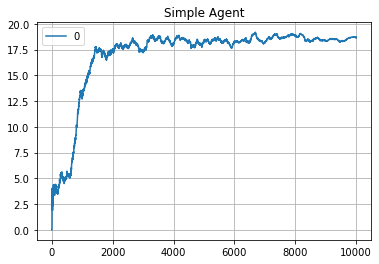

In [130]:
np.set_printoptions(precision=2)

nplayers = 3
nactions = 101
a = 10
b = 1
c = [0.,0.,0.]# [0.0,0.1,0.2]
scale = (nactions-1)/a*b

players = [DiscreteAgent(nactions, hidden_units=16, activation='elu') for i in range(nplayers)]
agent = DiscreteA2C(players, entropy_c=0.5)
env = RL1(scale=scale,nplayers=nplayers, a=a, b=b, c=c, max_episodes=1)
rewards_history = agent.train(env, 1, updates=10000)


Text(0.5, 1.0, 'Total Reward')

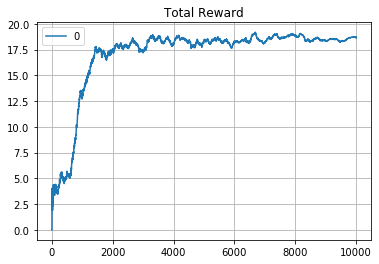

In [131]:
r = pd.DataFrame([np.sum(r) for r in rewards_history])
r.ewm(halflife=100).mean().plot()
plt.grid()
plt.title('Total Reward')